In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scripts.kaggle.helpers import make_submission
import datetime
from tqdm import tqdm
import gc
import itertools
from multiprocessing import Pool
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 16)

%load_ext autotime

Populating the interactive namespace from numpy and matplotlib


In [2]:
HEADER = ["fecha_dato", "ncodpers", "ind_empleado",
          "pais_residencia", "sexo", "age", "fecha_alta",
          "ind_nuevo", "antiguedad", "indrel", "ult_fec_cli_1t",
          "indrel_1mes", "tiprel_1mes", "indresi", "indext",
          "conyuemp", "canal_entrada", "indfall", "tipodom",
          "cod_prov", "nomprov", "ind_actividad_cliente",
          "renta", "segmento", "ind_ahor_fin_ult1",
          "ind_aval_fin_ult1", "ind_cco_fin_ult1",
          "ind_cder_fin_ult1", "ind_cno_fin_ult1",
          "ind_ctju_fin_ult1", "ind_ctma_fin_ult1",
          "ind_ctop_fin_ult1", "ind_ctpp_fin_ult1",
          "ind_deco_fin_ult1", "ind_deme_fin_ult1",
          "ind_dela_fin_ult1", "ind_ecue_fin_ult1",
          "ind_fond_fin_ult1", "ind_hip_fin_ult1",
          "ind_plan_fin_ult1", "ind_pres_fin_ult1",
          "ind_reca_fin_ult1", "ind_tjcr_fin_ult1",
          "ind_valo_fin_ult1", "ind_viv_fin_ult1",
          "ind_nomina_ult1", "ind_nom_pens_ult1",
          "ind_recibo_ult1"]

time: 8.32 ms


In [3]:
description, train, added_products, label_encoder, encoders = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/train_data.train_data', 'rb'))

time: 29.6 s


In [4]:
train.head()

,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,...,old_4_ind_actividad_cliente,old_4_segmento,old_4_pais_residencia,old_4_indrel,old_4_indresi,old_4_indext,old_4_conyuemp,old_4_indfall,old_4_nomprov,month
ncodpers,,,,,,,,,,,,,,,,,,,,,
15892,2,36,0,61,0.0,246.0,1.0,0,0,1,...,1.0,0.0,36.0,1.0,1.0,0.0,0.0,0.0,30.0,6
15897,0,36,2,61,0.0,246.0,1.0,0,0,1,...,1.0,0.0,36.0,1.0,1.0,0.0,0.0,0.0,30.0,6
15906,3,36,0,55,0.0,227.0,1.0,0,0,1,...,1.0,0.0,36.0,1.0,1.0,0.0,0.0,0.0,30.0,6
15925,2,36,2,62,0.0,246.0,1.0,0,0,1,...,1.0,1.0,36.0,1.0,1.0,0.0,0.0,0.0,30.0,6
15927,1,36,2,62,0.0,245.0,1.0,0,0,1,...,1.0,0.0,36.0,1.0,1.0,0.0,0.0,0.0,30.0,6


time: 42.1 ms


In [5]:
train.reset_index(inplace=True)

time: 3.35 ms


In [6]:
# for prefix in ['pf1_exists_at_least_1_', 'pf2_exists_all_months_', 'pf3_doesnt_exist_at_all_', 'pf4_product_removed_in_past_', 'pf5_product_added_in_past_', 'pf6_product_removed_recently_', 'pf7_product_added_recently_']:
#     subs = train.loc[:, ['current_'+h for h in HEADER[24:]]].astype(bool)
#     pf1 = train.loc[:, [prefix+h for h in HEADER[24:]]].astype(bool)
#     subs.columns = pf1.columns

#     new_pf1 = (pf1 & (~subs)).astype(int)

#     train.loc[:, [prefix+h for h in HEADER[24:]]] = new_pf1

time: 1.12 s


In [6]:
description, test1 = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/13.test_data1.test_data1', 'rb'))
test1.drop([500000], inplace=True)
description, test2 = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/13.test_data2.test_data2', 'rb'))
test = pd.concat((test1, test2))
test.set_index('ncodpers', inplace=True)
del test1, test2
gc.collect()
test.reset_index(inplace=True)

time: 1min 51s


---
# 17. product features positive if the the product doesnt exist, no user lag feature, nor raw attrs, no raw subs
---

In [8]:
# for prefix in ['pf1_exists_at_least_1_', 'pf2_exists_all_months_', 'pf3_doesnt_exist_at_all_', 'pf4_product_removed_in_past_', 'pf5_product_added_in_past_', 'pf6_product_removed_recently_', 'pf7_product_added_recently_']:
#     subs = test.loc[:, ['current_'+h for h in HEADER[24:]]].astype(bool)
#     pf1 = test.loc[:, [prefix+h for h in HEADER[24:]]].astype(bool)
#     subs.columns = pf1.columns

#     new_pf1 = (pf1 & (~subs)).astype(int)

#     test.loc[:, [prefix+h for h in HEADER[24:]]] = new_pf1

time: 4.47 s


In [7]:
user_attributes = ['age', 'ind_nuevo', 'antiguedad', 'indrel_1mes', 'tiprel_1mes',
                   'canal_entrada', 'ind_actividad_cliente', 'segmento',
                   'pais_residencia', 'indrel', 'indresi', 'indext', 'conyuemp',
                   'indfall', 'nomprov']

# for col in user_attributes:
#     del train['old_1_' + col], train['old_2_' + col], train['old_3_'+ col], train['old_4_' + col]
#     del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col], test['old_4_' + col]

# for col in user_attributes:
#     del train['uf1_changed_recently_' + col], train['uf2_changed_earlier_' + col], train['uf3_times_changed_'+ col]
#     del test['uf1_changed_recently_' + col], test['uf2_changed_earlier_' + col], test['uf3_times_changed_' + col]

time: 4.01 ms


In [10]:
# for col in HEADER[24:]:
#     del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col]
#     del train['old_1_' + col], train['old_2_' + col], train['old_3_' + col]

time: 11.7 s


In [20]:
jacob_train = pickle.load(open('data/15.Jacobian_similarity_features.train_data', 'rb'))
jacob_test = pickle.load(open('data/15.Jacobian_similarity_features.test_data', 'rb'))

jacob_added_last_2_train = pickle.load(open('data/15.Jacobian_similarity_features_added_in_last_2_months.train_data', 'rb'))
jacob_added_last_2_test = pickle.load(open('data/15.Jacobian_similarity_features_added_in_last_2_months.test_data', 'rb'))


time: 22.8 s


In [9]:
print train.shape
print test.shape
print jacob_train.shape
print jacob_test.shape
print jacob_added_last_2_train.shape
print jacob_added_last_2_test.shape

(441652, 389)
(929615, 389)
(441652, 48)
(929615, 48)
(441652, 48)
(929615, 48)
time: 3.17 ms


In [10]:
test.head()

,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,old_4_ind_actividad_cliente,old_4_segmento,old_4_pais_residencia,old_4_indrel,old_4_indresi,old_4_indext,old_4_conyuemp,old_4_indfall,old_4_nomprov,month
0,869505,3,36,0,26,0.0,75.0,1.0,0,0,...,1.0,1.0,36.0,1.0,1.0,0.0,2.0,0.0,3.0,6
1,1477437,3,36,0,22,0.0,8.0,1.0,0,0,...,0.0,2.0,36.0,1.0,1.0,0.0,2.0,0.0,30.0,6
2,1533309,3,36,0,52,1.0,4.0,1.0,0,1,...,0.0,3.0,36.0,1.0,1.0,0.0,2.0,0.0,14.0,6
3,1484304,3,36,0,25,0.0,8.0,1.0,0,1,...,0.0,2.0,36.0,1.0,1.0,0.0,2.0,0.0,30.0,6
4,1484306,3,36,0,22,0.0,8.0,1.0,0,1,...,0.0,2.0,36.0,1.0,1.0,0.0,2.0,0.0,30.0,6


time: 2.15 s


In [17]:
jacob_test.loc[1477437]

jacob_ind_ahor_fin_ult1     0.000082
cosine_ind_ahor_fin_ult1    0.006950
jacob_ind_aval_fin_ult1     0.000014
cosine_ind_aval_fin_ult1    0.002669
jacob_ind_cco_fin_ult1      0.000000
cosine_ind_cco_fin_ult1     0.000000
jacob_ind_cder_fin_ult1     0.000409
cosine_ind_cder_fin_ult1    0.017265
jacob_ind_cno_fin_ult1      0.011386
cosine_ind_cno_fin_ult1     0.035273
jacob_ind_ctju_fin_ult1     0.000005
cosine_ind_ctju_fin_ult1    0.000046
jacob_ind_ctma_fin_ult1     0.007710
cosine_ind_ctma_fin_ult1    0.064641
jacob_ind_ctop_fin_ult1     0.110624
cosine_ind_ctop_fin_ult1    0.277511
jacob_ind_ctpp_fin_ult1     0.031354
cosine_ind_ctpp_fin_ult1    0.132302
jacob_ind_deco_fin_ult1     0.000463
cosine_ind_deco_fin_ult1    0.019486
jacob_ind_deme_fin_ult1     0.001501
cosine_ind_deme_fin_ult1    0.035204
jacob_ind_dela_fin_ult1     0.037561
cosine_ind_dela_fin_ult1    0.162082
jacob_ind_ecue_fin_ult1     0.068433
cosine_ind_ecue_fin_ult1    0.197827
jacob_ind_fond_fin_ult1     0.017998
c

time: 5.25 ms


In [11]:
jacob_test.head()

,jacob_ind_ahor_fin_ult1,cosine_ind_ahor_fin_ult1,jacob_ind_aval_fin_ult1,cosine_ind_aval_fin_ult1,jacob_ind_cco_fin_ult1,cosine_ind_cco_fin_ult1,jacob_ind_cder_fin_ult1,cosine_ind_cder_fin_ult1,jacob_ind_cno_fin_ult1,cosine_ind_cno_fin_ult1,...,jacob_ind_valo_fin_ult1,cosine_ind_valo_fin_ult1,jacob_ind_viv_fin_ult1,cosine_ind_viv_fin_ult1,jacob_ind_nomina_ult1,cosine_ind_nomina_ult1,jacob_ind_nom_pens_ult1,cosine_ind_nom_pens_ult1,jacob_ind_recibo_ult1,cosine_ind_recibo_ult1
ncodpers,,,,,,,,,,,,,,,,,,,,,
15889,0.000884,0.021912,0.000769,0.033934,0.0,0.0,0.006847,0.075836,0.415941,0.796417,...,0.000000,0.000000,0.043409,0.182025,0.414067,0.755225,0.434003,0.794059,0.497496,1.088009
1170544,0.000082,0.006950,0.000014,0.002669,0.0,0.0,0.000409,0.017265,0.011386,0.035273,...,0.026649,0.137963,0.003207,0.044278,0.011827,0.043281,0.012634,0.044497,0.105950,0.256507
1170545,0.000082,0.006950,0.000014,0.002669,0.0,0.0,0.000409,0.017265,0.011386,0.035273,...,0.026649,0.137963,0.003207,0.044278,0.011827,0.043281,0.012634,0.044497,0.105950,0.256507
1170547,0.000082,0.006950,0.000014,0.002669,0.0,0.0,0.000409,0.017265,0.011386,0.035273,...,0.026649,0.137963,0.003207,0.044278,0.011827,0.043281,0.012634,0.044497,0.105950,0.256507
1170548,0.000082,0.006950,0.000014,0.002669,0.0,0.0,0.000409,0.017265,0.011386,0.035273,...,0.026649,0.137963,0.003207,0.044278,0.011827,0.043281,0.012634,0.044497,0.105950,0.256507


time: 7.5 s


In [12]:
train.head()

,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,old_4_ind_actividad_cliente,old_4_segmento,old_4_pais_residencia,old_4_indrel,old_4_indresi,old_4_indext,old_4_conyuemp,old_4_indfall,old_4_nomprov,month
0,15892,2,36,0,61,0.0,246.0,1.0,0,0,...,1.0,0.0,36.0,1.0,1.0,0.0,0.0,0.0,30.0,6
1,15897,0,36,2,61,0.0,246.0,1.0,0,0,...,1.0,0.0,36.0,1.0,1.0,0.0,0.0,0.0,30.0,6
2,15906,3,36,0,55,0.0,227.0,1.0,0,0,...,1.0,0.0,36.0,1.0,1.0,0.0,0.0,0.0,30.0,6
3,15925,2,36,2,62,0.0,246.0,1.0,0,0,...,1.0,1.0,36.0,1.0,1.0,0.0,0.0,0.0,30.0,6
4,15927,1,36,2,62,0.0,245.0,1.0,0,0,...,1.0,0.0,36.0,1.0,1.0,0.0,0.0,0.0,30.0,6


time: 29.6 ms


In [13]:
jacob_train.head()

,jacob_ind_ahor_fin_ult1,cosine_ind_ahor_fin_ult1,jacob_ind_aval_fin_ult1,cosine_ind_aval_fin_ult1,jacob_ind_cco_fin_ult1,cosine_ind_cco_fin_ult1,jacob_ind_cder_fin_ult1,cosine_ind_cder_fin_ult1,jacob_ind_cno_fin_ult1,cosine_ind_cno_fin_ult1,...,jacob_ind_valo_fin_ult1,cosine_ind_valo_fin_ult1,jacob_ind_viv_fin_ult1,cosine_ind_viv_fin_ult1,jacob_ind_nomina_ult1,cosine_ind_nomina_ult1,jacob_ind_nom_pens_ult1,cosine_ind_nom_pens_ult1,jacob_ind_recibo_ult1,cosine_ind_recibo_ult1
ncodpers,,,,,,,,,,,,,,,,,,,,,
15892,0.001922,0.042186,0.001856,0.084516,0.315905,1.033608,0.010739,0.118331,0.000000,0.000000,...,0.000000,0.000000,0.079300,0.317117,1.662739,2.576130,1.702099,2.618801,0.000000,0.000000
15897,0.003068,0.068065,0.002182,0.096053,0.000000,0.000000,0.017038,0.181267,0.000000,0.000000,...,0.000000,0.000000,0.114651,0.481117,1.750465,2.822744,1.789703,2.866702,0.000000,0.000000
15906,0.001816,0.041220,0.001136,0.056974,0.362383,1.063298,0.006653,0.085441,0.000000,0.000000,...,0.439234,0.959849,0.074186,0.322716,1.462919,2.324312,1.492736,2.353052,0.000000,0.000000
15925,0.000642,0.024398,0.000412,0.020984,0.000000,0.000000,0.002701,0.050439,0.344700,0.603161,...,0.171709,0.454029,0.030876,0.177510,0.308773,0.546272,0.313498,0.552792,0.425316,0.840093
15927,0.001608,0.023118,0.000558,0.025156,0.150713,0.511194,0.006105,0.046694,0.635437,1.164962,...,0.224904,0.506582,0.045052,0.153827,0.538950,1.053044,0.546324,1.061477,0.000000,0.000000


time: 32.5 ms


In [21]:
jacob_added_last_2_test.head()

,jacob_added_2_old_ind_ahor_fin_ult1,cosine_added_2_old_ind_ahor_fin_ult1,jacob_added_2_old_ind_aval_fin_ult1,cosine_added_2_old_ind_aval_fin_ult1,jacob_added_2_old_ind_cco_fin_ult1,cosine_added_2_old_ind_cco_fin_ult1,jacob_added_2_old_ind_cder_fin_ult1,cosine_added_2_old_ind_cder_fin_ult1,jacob_added_2_old_ind_cno_fin_ult1,cosine_added_2_old_ind_cno_fin_ult1,...,jacob_added_2_old_ind_valo_fin_ult1,cosine_added_2_old_ind_valo_fin_ult1,jacob_added_2_old_ind_viv_fin_ult1,cosine_added_2_old_ind_viv_fin_ult1,jacob_added_2_old_ind_nomina_ult1,cosine_added_2_old_ind_nomina_ult1,jacob_added_2_old_ind_nom_pens_ult1,cosine_added_2_old_ind_nom_pens_ult1,jacob_added_2_old_ind_recibo_ult1,cosine_added_2_old_ind_recibo_ult1
ncodpers,,,,,,,,,,,,,,,,,,,,,
15889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1170544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1170545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1170547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1170548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 27.9 ms


In [26]:
added_products.head()

,added_product,encoded_products
ncodpers,,
15892,ind_cco_fin_ult1,2
15897,ind_nom_pens_ult1,15
15906,ind_nom_pens_ult1,15
15925,ind_recibo_ult1,20
15927,ind_cco_fin_ult1,2


time: 7.08 ms


In [22]:
test.set_index('ncodpers', inplace=True)
train.set_index('ncodpers', inplace=True)
for col in ['jacob_'+h for h in HEADER[24:]]:
    test[col] = jacob_test[col]
    train[col] = jacob_train[col]
for col in ['jacob_added_2_old_'+h for h in HEADER[24:]]:
    test[col] = jacob_added_last_2_test[col]
    train[col] = jacob_added_last_2_train[col]

time: 1.64 s


In [23]:
print train.shape
print test.shape

(441652, 436)
(929615, 436)
time: 1.53 ms


In [24]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

time: 3.5 s


In [25]:
def test_train_split(df, test_frac):
    n = int(len(df)*test_frac)
    rows = df.sample(n).index
    test = df.ix[rows]
    train = df.drop(rows)
    return test, train, rows

def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

time: 6.69 ms


In [27]:
train.reset_index(inplace=True)
# test.reset_index(inplace=True)
added_products.reset_index(inplace=True)
cv, tr, rows = test_train_split(train, 0.05)


cv_y = added_products.ix[rows]
tr_y = added_products.drop(rows)

cv.set_index('ncodpers', inplace=True)
tr.set_index('ncodpers', inplace=True)

print cv.shape, cv_y.shape
print tr.shape, tr_y.shape


dtr = xgb.DMatrix(tr, label=tr_y.encoded_products)
dcv = xgb.DMatrix(cv, label=cv_y.encoded_products)



param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}
evallist = [(dtr, 'train'), (dcv, 'cv')]

(22082, 436) (22082, 3)
(419570, 436) (419570, 3)
time: 6.91 s


In [28]:
xgb_model = xgb.train(plist, dtr, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.759027	cv-MAP@7:0.755683
[1]	train-MAP@7:0.763837	cv-MAP@7:0.758446
[2]	train-MAP@7:0.765815	cv-MAP@7:0.759986
[3]	train-MAP@7:0.767023	cv-MAP@7:0.760982
[4]	train-MAP@7:0.767543	cv-MAP@7:0.761389
[5]	train-MAP@7:0.768685	cv-MAP@7:0.762069
[6]	train-MAP@7:0.76928	cv-MAP@7:0.762386
[7]	train-MAP@7:0.769745	cv-MAP@7:0.762567
[8]	train-MAP@7:0.77005	cv-MAP@7:0.762839
[9]	train-MAP@7:0.770291	cv-MAP@7:0.763337
[10]	train-MAP@7:0.770715	cv-MAP@7:0.763563
[11]	train-MAP@7:0.770946	cv-MAP@7:0.764016
[12]	train-MAP@7:0.771304	cv-MAP@7:0.764016
[13]	train-MAP@7:0.77158	cv-MAP@7:0.764378
[14]	train-MAP@7:0.771742	cv-MAP@7:0.764559
[15]	train-MAP@7:0.771943	cv-MAP@7:0.764741
[16]	train-MAP@7:0.772164	cv-MAP@7:0.764741
[17]	train-MAP@7:0.772415	cv-MAP@7:0.765148
[18]	train-MAP@7:0.772591	cv-MAP@7:0.764876
[19]	train-MAP@7:0.772708	cv-MAP@7:0.764967
[20]	train-MAP@7:0.772877	cv-MAP@7:0.765284
[21]	train-MAP@7:0.773127	cv-MAP@7:0.765193
[22]	train-MAP@7:0.773261	cv-MAP@7:0.764922
[

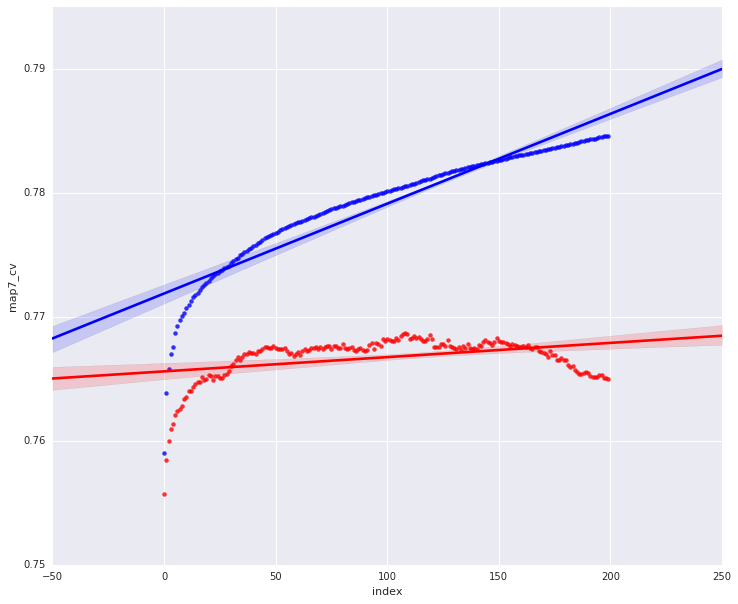

time: 1.64 s


In [29]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [30]:
def get_n_iter_from_evals_results(p2):
    max_df = p2.loc[p2.map7_cv == p2.map7_cv.max(), :]
    print max_df
    n = max_df.index.max()
    return n

optimal_index = get_n_iter_from_evals_results(p2)
optimal_n = int(optimal_index/0.95)
print "@@@@@@@@ Results @@@@@@@@"
print optimal_n, 'optimal_n', optimal_index

     index  map7_train  map7_cv
108    108    0.780521  0.76868
@@@@@@@@ Results @@@@@@@@
113 optimal_n 108
time: 7.98 ms


In [31]:
optimal_n = 120

time: 818 µs


In [32]:
train.set_index('ncodpers', inplace=True)
added_products.set_index('ncodpers', inplace=True)
# test.set_index('ncodpers', inplace=True)


dtrain = xgb.DMatrix(train, label=added_products.encoded_products)

time: 5.3 s


In [33]:
print train.shape, test.shape,added_products.shape

(441652, 436) (929615, 436) (441652, 2)
time: 1.18 ms


In [34]:
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.762738	cv-MAP@7:0.759759
[1]	train-MAP@7:0.765662	cv-MAP@7:0.762386
[2]	train-MAP@7:0.766282	cv-MAP@7:0.762839
[3]	train-MAP@7:0.767119	cv-MAP@7:0.76379
[4]	train-MAP@7:0.768012	cv-MAP@7:0.76465
[5]	train-MAP@7:0.768551	cv-MAP@7:0.765465
[6]	train-MAP@7:0.76903	cv-MAP@7:0.766009
[7]	train-MAP@7:0.769304	cv-MAP@7:0.766688
[8]	train-MAP@7:0.769581	cv-MAP@7:0.76696
[9]	train-MAP@7:0.769824	cv-MAP@7:0.766778
[10]	train-MAP@7:0.770336	cv-MAP@7:0.767729
[11]	train-MAP@7:0.770794	cv-MAP@7:0.768092
[12]	train-MAP@7:0.771237	cv-MAP@7:0.768318
[13]	train-MAP@7:0.771533	cv-MAP@7:0.768771
[14]	train-MAP@7:0.771747	cv-MAP@7:0.769179
[15]	train-MAP@7:0.771919	cv-MAP@7:0.769133
[16]	train-MAP@7:0.772169	cv-MAP@7:0.769179
[17]	train-MAP@7:0.77235	cv-MAP@7:0.769314
[18]	train-MAP@7:0.772458	cv-MAP@7:0.769767
[19]	train-MAP@7:0.772689	cv-MAP@7:0.769722
[20]	train-MAP@7:0.772832	cv-MAP@7:0.769948
[21]	train-MAP@7:0.772975	cv-MAP@7:0.769813
[22]	train-MAP@7:0.773051	cv-MAP@7:0.769903
[23

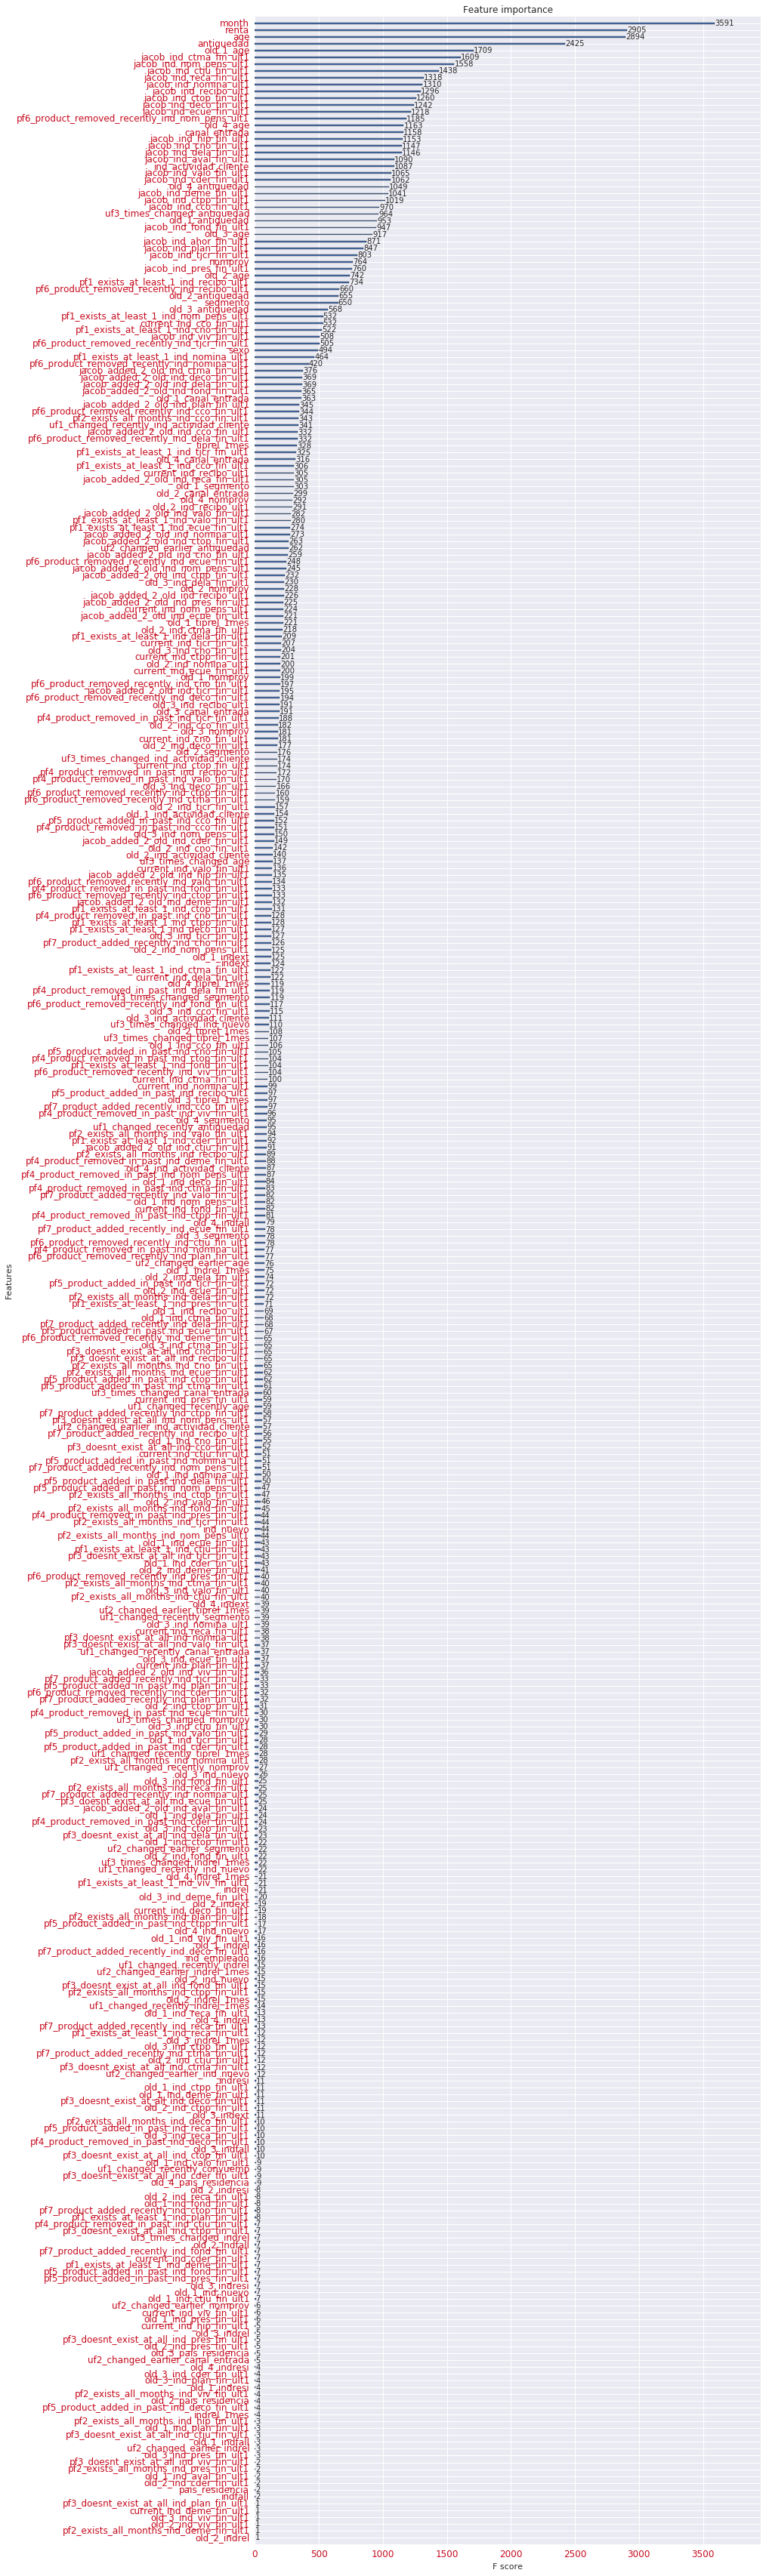

time: 6.04 s


In [35]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(main_xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

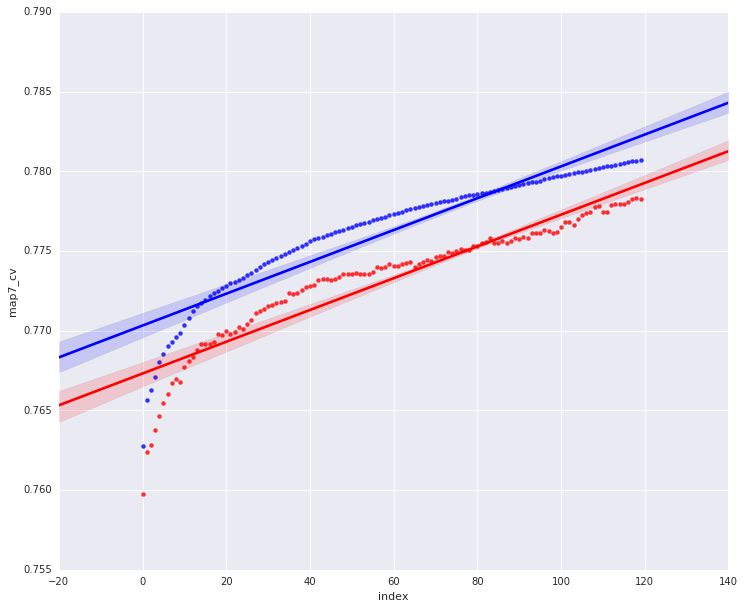

time: 384 ms


In [36]:
p2 = pd.DataFrame()
p2['index'] = range(0, optimal_n)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [37]:
main_xgb_model.save_model('data/18.xgboost_model_save.xgb')
make_submission('data/18.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

Compressing file
Compression done
Uploading file to s3 data/18.xgboost_model_save.xgb.zip
uploading to s3 done
time: 574 ms


In [38]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)

time: 35.6 s


In [39]:
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [15:04<00:00, 1028.00it/s]

time: 15min 7s


In [40]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/18.xgb_trained_product_feats_product_lags_jacobian_similarities_jacobian_added_similarities.csv'
description = '18. xgb trained product features product lags, jacobian similarities, jacobian added simiarities\
               product raw lags' +\
                str(param) + " iterations " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/18.xgb_trained_product_feats_product_lags_jacobian_similarities_jacobian_added_similarities.csv.zip
uploading to s3 done
Uploading submission data/18.xgb_trained_product_feats_product_lags_jacobian_similarities_jacobian_added_similarities.csv.zip
Upload done
time: 24.9 s


In [41]:
pickle_description = '18 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/18.xgb_trained_product_feats_product_lags_jacobian_similarities_jacobian_added_similarities.csv.pickle.zip
uploading to s3 done
time: 1min 49s


----
# 17.1 Jacobian similarities with above product sub related features
----

In [25]:
del test['xgb_preds'], test['added_products']

jacob_train = pickle.load(open('data/15.Jacobian_similarity_features.train_data', 'rb'))
jacob_test = pickle.load(open('data/15.Jacobian_similarity_features.test_data', 'rb'))

for col in ['jacob_'+h for h in HEADER[24:]]:
    test[col] = jacob_test[col]
    train[col] = jacob_train[col]

time: 16.8 s


In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
added_products.head()

In [27]:
print train.shape
print test.shape
print added_products.shape

(441652, 235)
(929615, 235)
(441652, 2)
time: 1.46 ms


In [28]:
train.reset_index(inplace=True)
# test.reset_index(inplace=True)
added_products.reset_index(inplace=True)
cv, tr, rows = test_train_split(train, 0.05)


cv_y = added_products.ix[rows]
tr_y = added_products.drop(rows)

cv.set_index('ncodpers', inplace=True)
tr.set_index('ncodpers', inplace=True)

print cv.shape, cv_y.shape
print tr.shape, tr_y.shape


dtr = xgb.DMatrix(tr, label=tr_y.encoded_products)
dcv = xgb.DMatrix(cv, label=cv_y.encoded_products)



param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}
evallist = [(dtr, 'train'), (dcv, 'cv')]

(22082, 235) (22082, 3)
(419570, 235) (419570, 3)
time: 4.05 s


In [29]:
xgb_model = xgb.train(plist, dtr, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.75978	cv-MAP@7:0.760212
[1]	train-MAP@7:0.765298	cv-MAP@7:0.766824
[2]	train-MAP@7:0.766401	cv-MAP@7:0.768001
[3]	train-MAP@7:0.766821	cv-MAP@7:0.768409
[4]	train-MAP@7:0.76821	cv-MAP@7:0.76868
[5]	train-MAP@7:0.768353	cv-MAP@7:0.768726
[6]	train-MAP@7:0.768453	cv-MAP@7:0.768726
[7]	train-MAP@7:0.769073	cv-MAP@7:0.769224
[8]	train-MAP@7:0.769404	cv-MAP@7:0.76936
[9]	train-MAP@7:0.769552	cv-MAP@7:0.768635
[10]	train-MAP@7:0.769617	cv-MAP@7:0.768635
[11]	train-MAP@7:0.769988	cv-MAP@7:0.768726
[12]	train-MAP@7:0.7702	cv-MAP@7:0.769088
[13]	train-MAP@7:0.770355	cv-MAP@7:0.76936
[14]	train-MAP@7:0.770494	cv-MAP@7:0.768862
[15]	train-MAP@7:0.770856	cv-MAP@7:0.769133
[16]	train-MAP@7:0.77107	cv-MAP@7:0.769405
[17]	train-MAP@7:0.771225	cv-MAP@7:0.769541
[18]	train-MAP@7:0.771323	cv-MAP@7:0.76936
[19]	train-MAP@7:0.77144	cv-MAP@7:0.769496
[20]	train-MAP@7:0.771642	cv-MAP@7:0.769586
[21]	train-MAP@7:0.771745	cv-MAP@7:0.769586
[22]	train-MAP@7:0.77184	cv-MAP@7:0.769677
[23]	trai

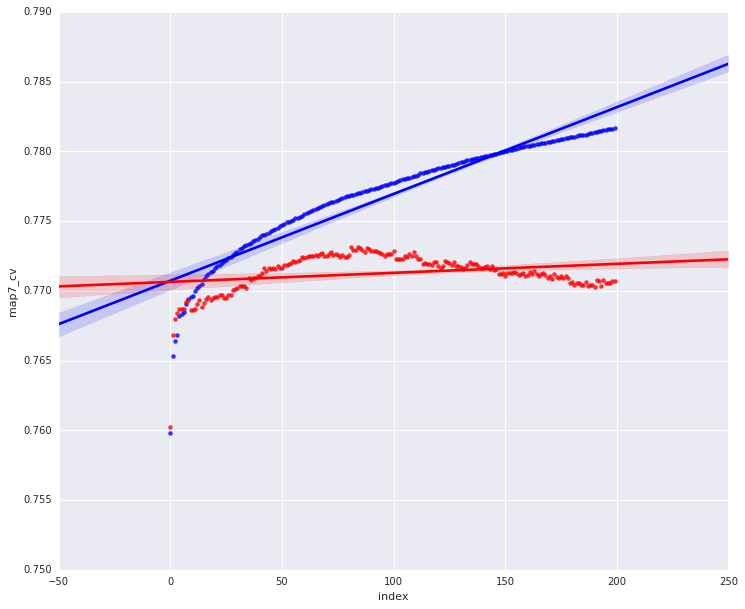

time: 428 ms


In [30]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [31]:
def get_n_iter_from_evals_results(p2):
    max_df = p2.loc[p2.map7_cv == p2.map7_cv.max(), :]
    print max_df
    n = max_df.index.max()
    return n

optimal_index = get_n_iter_from_evals_results(p2)
optimal_n = int(optimal_index/0.95)
print "@@@@@@@@ Results @@@@@@@@"
print optimal_n, 'optimal_n', optimal_index

    index  map7_train   map7_cv
84     84    0.776991  0.773164
@@@@@@@@ Results @@@@@@@@
88 optimal_n 84
time: 7.09 ms


In [32]:
optimal_n = 110

time: 841 µs


In [33]:
train.set_index('ncodpers', inplace=True)
added_products.set_index('ncodpers', inplace=True)
# test.set_index('ncodpers', inplace=True)


dtrain = xgb.DMatrix(train, label=added_products.encoded_products)

time: 2.87 s


In [34]:
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.757149	cv-MAP@7:0.760801
[1]	train-MAP@7:0.763513	cv-MAP@7:0.766326
[2]	train-MAP@7:0.764564	cv-MAP@7:0.768046
[3]	train-MAP@7:0.767305	cv-MAP@7:0.770265
[4]	train-MAP@7:0.767669	cv-MAP@7:0.771443
[5]	train-MAP@7:0.76811	cv-MAP@7:0.771986
[6]	train-MAP@7:0.768625	cv-MAP@7:0.771624
[7]	train-MAP@7:0.768985	cv-MAP@7:0.77185
[8]	train-MAP@7:0.769149	cv-MAP@7:0.771986
[9]	train-MAP@7:0.769519	cv-MAP@7:0.771398
[10]	train-MAP@7:0.769786	cv-MAP@7:0.771805
[11]	train-MAP@7:0.769948	cv-MAP@7:0.772394
[12]	train-MAP@7:0.770153	cv-MAP@7:0.772394
[13]	train-MAP@7:0.770305	cv-MAP@7:0.772983
[14]	train-MAP@7:0.770448	cv-MAP@7:0.772666
[15]	train-MAP@7:0.770639	cv-MAP@7:0.772394
[16]	train-MAP@7:0.770782	cv-MAP@7:0.772349
[17]	train-MAP@7:0.770908	cv-MAP@7:0.772937
[18]	train-MAP@7:0.771123	cv-MAP@7:0.773209
[19]	train-MAP@7:0.771304	cv-MAP@7:0.773028
[20]	train-MAP@7:0.771418	cv-MAP@7:0.773209
[21]	train-MAP@7:0.771566	cv-MAP@7:0.7733
[22]	train-MAP@7:0.771719	cv-MAP@7:0.77339
[23

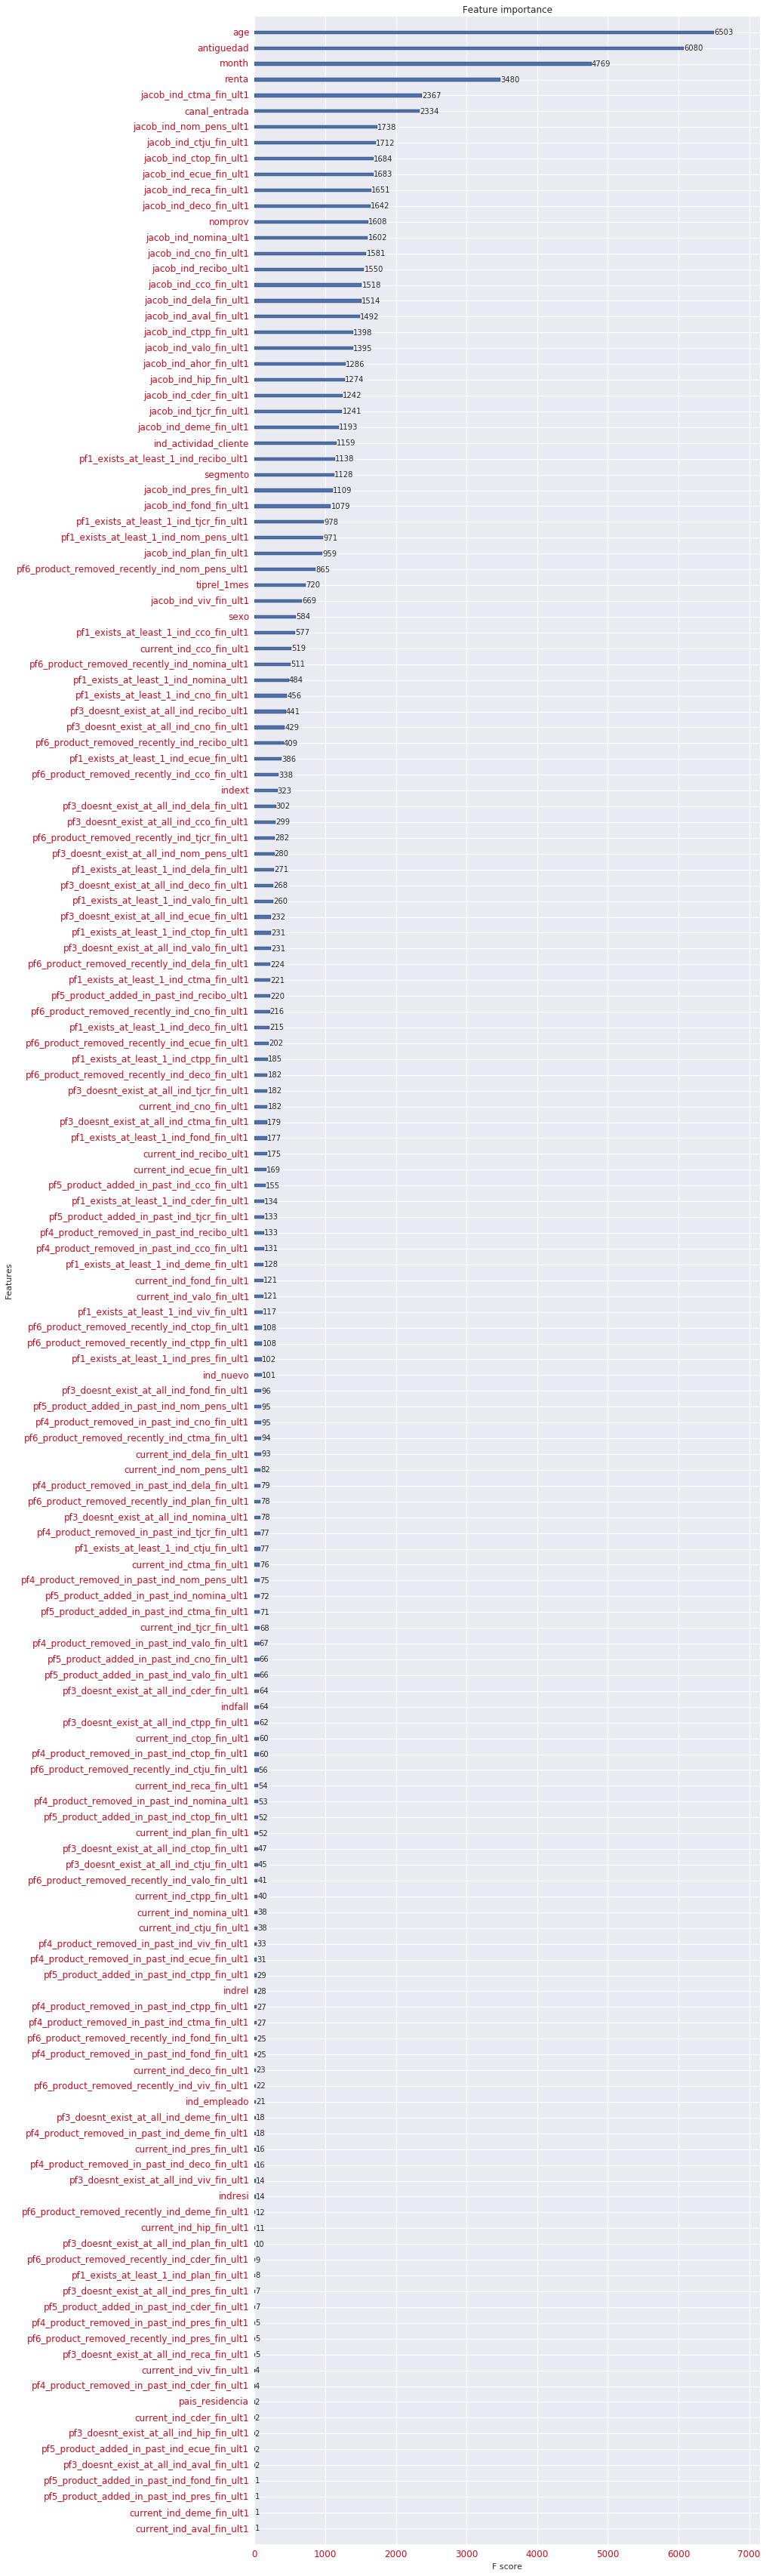

time: 3.31 s


In [35]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(main_xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

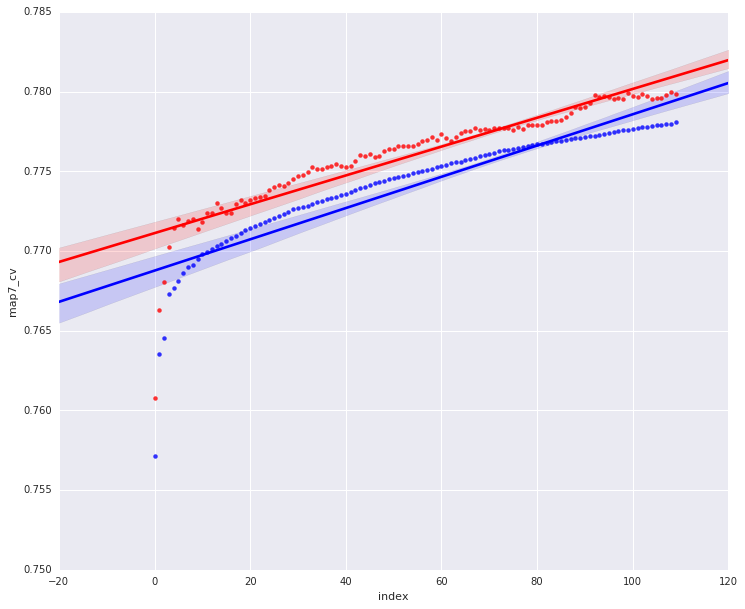

time: 382 ms


In [36]:
p2 = pd.DataFrame()
p2['index'] = range(0, optimal_n)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [37]:
main_xgb_model.save_model('data/17.1.xgboost_model_save.xgb')
make_submission('data/17.1.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

Compressing file
Compression done
Uploading file to s3 data/17.1.xgboost_model_save.xgb.zip
uploading to s3 done
time: 623 ms


In [38]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)

time: 27.9 s


In [39]:
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [11:49<00:00, 1311.11it/s]

time: 11min 52s


In [40]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/17.1.xgb_trained_on_all_months_jacobian_change_subs.csv'
description = '17.1 jacobians plus subs features that are true for unsubscribed products,\
                no user attrs, no user lags, no subs lags' +\
                str(param) + " iterations " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/17.1.xgb_trained_on_all_months_jacobian_change_subs.csv.zip
uploading to s3 done
Uploading submission data/17.1.xgb_trained_on_all_months_jacobian_change_subs.csv.zip
Upload done
time: 19.9 s


In [41]:
pickle_description = '17.1 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/17.1.xgb_trained_on_all_months_jacobian_change_subs.csv.pickle.zip
uploading to s3 done
time: 1min 52s
